In [2]:
import torch  
import torchvision.transforms as transforms  
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import os   
import pathlib  
import time   
import datetime  
import glob 


from matplotlib import pyplot as plt  
from IPython.display import display 
from PIL import Image   

In [3]:
import os
from PIL import Image
import torchvision.transforms as transforms

# Path to the dataset
PATH = '/kaggle/input/cityscapes-pix2pix-dataset/' 
train_path = os.path.join(PATH, 'train')
val_path = os.path.join(PATH, 'val')

# Function to count images in a directory
def count_images_in_directory(directory):
    if not os.path.exists(directory):
        return 0
    image_files = [f for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.jpeg'))]
    return len(image_files)

# Count images in train and validation sets
num_train_images = count_images_in_directory(train_path)
num_val_images = count_images_in_directory(val_path)

# Print dataset information
print(f"Dataset Information:")
print(f" - Number of train images: {num_train_images}")
print(f" - Number of validation images: {num_val_images}")

# Load a sample image from the train set
if num_train_images > 0:
    image_path = os.path.join(train_path, '1.jpg')
    sample_image = Image.open(image_path)

    # Convert image to tensor
    transform = transforms.ToTensor()
    sample_image_tensor = transform(sample_image)

    # Print sample image information
    print("\nSample Train Image Information:")
    print(f" - Image path: {image_path}")
    print(f" - Image size: {sample_image.size}")
    print(f" - Tensor shape: {sample_image_tensor.shape}")
else:
    print("\nNo train images found.")


Dataset Information:
 - Number of train images: 2975
 - Number of validation images: 500

Sample Train Image Information:
 - Image path: /kaggle/input/cityscapes-pix2pix-dataset/train/1.jpg
 - Image size: (512, 256)
 - Tensor shape: torch.Size([3, 256, 512])


In [4]:
def random_crop(input_image, real_image, IMG_HEIGHT, IMG_WIDTH):

    _, H, W = input_image.shape

    if H < IMG_HEIGHT or W < IMG_WIDTH:
        raise ValueError("The requested crop size is larger than the input image size.")

    top = random.randint(0, H - IMG_HEIGHT)
    left = random.randint(0, W - IMG_WIDTH)

    input_cropped = input_image[:, top:top+IMG_HEIGHT, left:left+IMG_WIDTH]
    real_cropped = real_image[:, top:top+IMG_HEIGHT, left:left+IMG_WIDTH]

    return input_cropped, real_cropped

In [5]:
def load(image_file):  
    # Read the image file  
    image = Image.open(image_file)  

    # Convert the image to a tensor  
    transform = transforms.ToTensor() 
    image_tensor = transform(image)  
 
    w = image_tensor.size(2)  
    w //= 2 
    real_image = image_tensor[:, :, :w]   
    input_image = image_tensor[:, :, w:]  

    # Convert both images to float32 tensors  
    input_image = input_image.float()  
    real_image = real_image.float()  
   
    return random_crop(input_image, real_image,256,256)


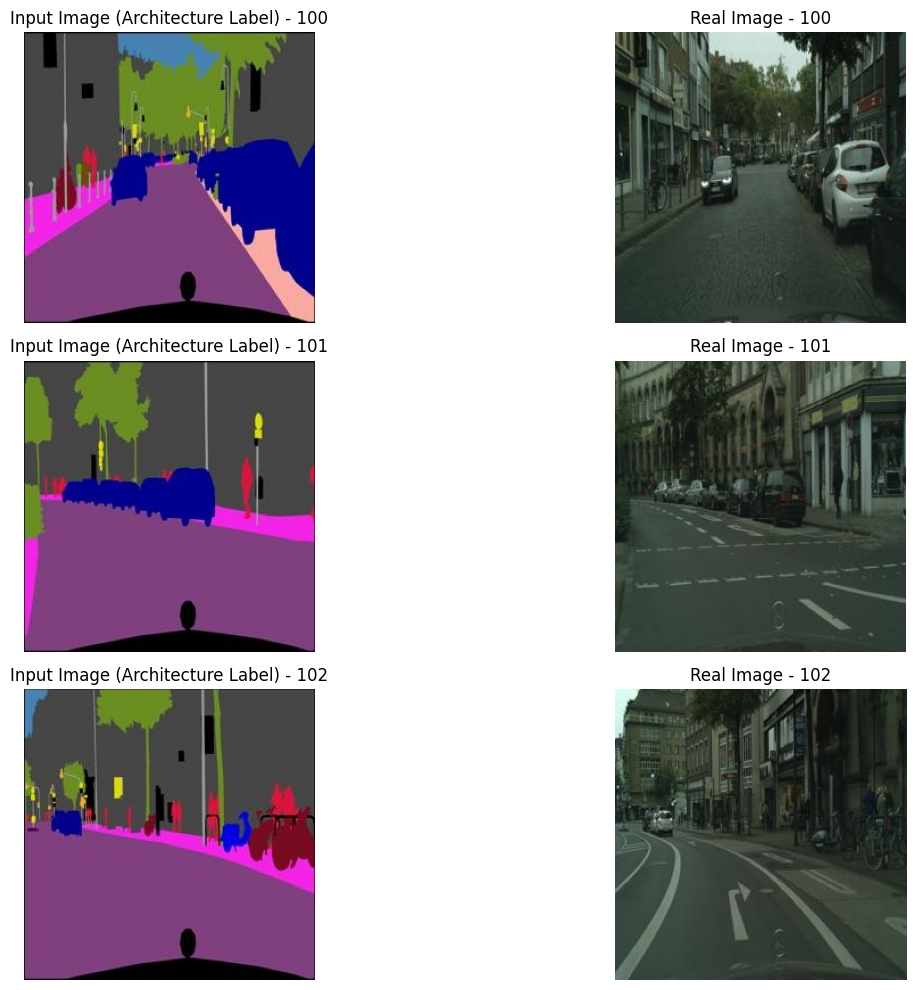

In [6]:
image_indices = [100, 101, 102]   

# Create a figure for plotting  
plt.figure(figsize=(15, 10))   

for i, index in enumerate(image_indices):  
    inp, re = load(str(PATH + f'train/{index}.jpg'))  

    # Display input image  
    plt.subplot(3, 2, 2 * i + 1)   
    plt.imshow(inp.permute(1, 2, 0)) 
    plt.title(f"Input Image (Architecture Label) - {index}")  
    plt.axis('off')  # Hide axes  

    # Display real image  
    plt.subplot(3, 2, 2 * i + 2)  
    plt.imshow(re.permute(1, 2, 0))  
    plt.title(f"Real Image - {index}")  
    plt.axis('off')   

plt.tight_layout()  
plt.show()

In [7]:
# Define the paths to your train and validation directories  
train_path = '/kaggle/input/cityscapes-pix2pix-dataset/train'  
val_path = '/kaggle/input/cityscapes-pix2pix-dataset/val'  


num_train_images = len([name for name in os.listdir(train_path) if name.endswith(('.jpg'))])   
num_val_images = len([name for name in os.listdir(val_path) if name.endswith(('.jpg'))])  

print(f'Number of training images: {num_train_images}')  
print(f'Number of validation images: {num_val_images}')

Number of training images: 2975
Number of validation images: 500


In [8]:
BUFFER_SIZE = 2975
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.image_paths = glob.glob(os.path.join(root_dir, f'{split}/*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        input_image, real_image = load(image_path) # Uses the previously defined load function


        if self.transform:
            # Optionally apply user-defined transforms
            input_image = self.transform(input_image)
            real_image = self.transform(real_image)

        return input_image, real_image


common_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
])

# Create train dataset and loader
train_dataset = Pix2PixDataset(root_dir=PATH, split='train', transform=common_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


test_dataset = Pix2PixDataset(root_dir=PATH, split='val', transform=common_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [10]:
OUTPUT_CHANNELS = 3

In [11]:
def downsample(in_channels, out_channels, size, apply_batchnorm=True):
    layers = []
    padding = (size - 2) // 2 

    # Add Conv2D layer
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=size, stride=2, padding=padding, bias=not apply_batchnorm))
    nn.init.normal_(layers[-1].weight, 0.0, 0.02)
    if layers[-1].bias is not None:
        nn.init.zeros_(layers[-1].bias)
    
    # Add normalization only if spatial size > 1x1
    if apply_batchnorm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    # Add activation
    layers.append(nn.LeakyReLU(0.2))
    
    return nn.Sequential(*layers)

In [12]:
inp = torch.randn(3, 256, 256)  # Example input

down_model = downsample(in_channels=3, out_channels=3, size=4)

inp = inp.unsqueeze(0)

down_result = down_model(inp)

print(down_result.shape)  


torch.Size([1, 3, 128, 128])


In [13]:
def upsample(in_channels, out_channels, size, apply_dropout=False):
    layers = []
    padding = (size - 2) // 2  # Calculate padding for 'same' convolution
    
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=size, stride=2, padding=padding, bias=False))
    nn.init.normal_(layers[-1].weight, 0.0, 0.02)
    
    layers.append(nn.BatchNorm2d(out_channels))
    
    if apply_dropout:
        layers.append(nn.Dropout(0.5))
    
    layers.append(nn.ReLU())
    
    return nn.Sequential(*layers)


In [14]:
down_result = torch.randn(1, 3, 128, 128)  

up_model = upsample(in_channels=3, out_channels=3, size=4, apply_dropout=False)
up_result = up_model(down_result)

print(up_result.shape) 

torch.Size([1, 3, 256, 256])


In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Downsampling stack
        self.down_stack = nn.ModuleList([
            downsample(3, 64, 4, apply_batchnorm=False),  
            downsample(64, 128, 4),                      
            downsample(128, 256, 4),                     
            downsample(256, 512, 4),                     
            downsample(512, 512, 4),                     
            downsample(512, 512, 4),                     
            downsample(512, 512, 4),                     
            downsample(512, 512, 4, apply_batchnorm=False),  
        ])

        # Upsampling stack remains unchanged
        self.up_stack = nn.ModuleList([
            upsample(512, 512, 4, apply_dropout=True),   
            upsample(1024, 512, 4, apply_dropout=True),  
            upsample(1024, 512, 4, apply_dropout=True),  
            upsample(1024, 512, 4),                      
            upsample(1024, 256, 4),                      
            upsample(512, 128, 4),                       
            upsample(256, 64, 4),                       
        ])

        # Final layer
        self.last = nn.ConvTranspose2d(128, OUTPUT_CHANNELS, kernel_size=4, stride=2, padding=1)
        nn.init.normal_(self.last.weight, 0.0, 0.02)
        if self.last.bias is not None:
            nn.init.zeros_(self.last.bias)

        self.tanh = nn.Tanh()

    def forward(self, x):
        # Downsampling
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)
        
        skips = skips[:-1][::-1]  # Reverse skips except the last layer

        # Upsampling
        for i, up in enumerate(self.up_stack):
            x = up(x)
            if i < len(skips):  # Skip connections
                skip = skips[i]
                x = torch.cat([x, skip], dim=1)

        x = self.last(x)
        x = self.tanh(x)
        return x

In [16]:
gen = Generator()
inp = torch.randn(1, 3, 256, 256)  # Example input: batch of 1, RGB image, 256x256
out = gen(inp)
print(out.shape)  # Should be [1, 3, 256, 256]


torch.Size([1, 3, 256, 256])


In [17]:
LAMBDA = 100

In [18]:
def generator_loss(disc_generated_output, gen_output, target, lambda_l1=100):
  
    gan_loss = F.binary_cross_entropy_with_logits(disc_generated_output, torch.ones_like(disc_generated_output))

    # L1 loss: Mean absolute error between generated and target images
    l1_loss = F.l1_loss(gen_output, target)

    # Total generator loss
    total_gen_loss = gan_loss + lambda_l1 * l1_loss

    return total_gen_loss, gan_loss, l1_loss


In [19]:
def downsample(in_channels, out_channels, kernel_size, apply_batchnorm=True):
    layers = []
    layers.append(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=2,
            padding=1,  
            bias=not apply_batchnorm,
        )
    )
    nn.init.normal_(layers[-1].weight, 0.0, 0.02)
    if layers[-1].bias is not None:
        nn.init.zeros_(layers[-1].bias)

    if apply_batchnorm:
        layers.append(nn.BatchNorm2d(out_channels))

    layers.append(nn.LeakyReLU(0.2))

    return nn.Sequential(*layers)


# PatchGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Downsampling layers
        self.down1 = downsample(6, 64, 4, apply_batchnorm=False)  
        self.down2 = downsample(64, 128, 4)
        self.down3 = downsample(128, 256, 4)

        # Zero padding + Conv2D
        self.zero_pad1 = nn.ZeroPad2d(1)  
        self.conv = nn.Conv2d(256, 512, kernel_size=4, stride=1, bias=False)
        nn.init.normal_(self.conv.weight, 0.0, 0.02)

        self.batchnorm1 = nn.BatchNorm2d(512)
        self.leaky_relu = nn.LeakyReLU(0.2)

        # Zero padding + Last Conv2D
        self.zero_pad2 = nn.ZeroPad2d(1)
        self.last = nn.Conv2d(512, 1, kernel_size=4, stride=1)  
        nn.init.normal_(self.last.weight, 0.0, 0.02)
        if self.last.bias is not None:
            nn.init.zeros_(self.last.bias)

    def forward(self, input_image, target_image):
        # Concatenate input and target images along the channel dimension
        x = torch.cat([input_image, target_image], dim=1)  

        x = self.down1(x)  
        x = self.down2(x)  
        x = self.down3(x)  

        x = self.zero_pad1(x)  
        x = self.conv(x)       
        x = self.batchnorm1(x)
        x = self.leaky_relu(x)

        x = self.zero_pad2(x)  
        x = self.last(x)       

        return x


In [20]:
def discriminator_loss(disc_real_output, disc_generated_output):
    
    real_loss = F.binary_cross_entropy_with_logits(disc_real_output, torch.ones_like(disc_real_output))

    generated_loss = F.binary_cross_entropy_with_logits(disc_generated_output, torch.zeros_like(disc_generated_output))

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss, real_loss, generated_loss


In [21]:
generator = Generator() 
discriminator = Discriminator()  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

generator_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

print(f"Using device: {device}")

Using device: cuda


In [22]:
def display_images(input_image, target_image, generated_image, epoch, batch_idx):
    plt.figure(figsize=(15, 15))

    display_list = [
        input_image[0].permute(1, 2, 0).cpu().numpy(), 
        target_image[0].permute(1, 2, 0).cpu().numpy(), 
        generated_image[0].permute(1, 2, 0).cpu().numpy() 
    ]
    titles = ['Input Image', 'Segmented Target', 'Generated Image']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}, Batch {batch_idx}")
    plt.show()

In [23]:
def train_step(generator, discriminator, generator_optimizer, discriminator_optimizer, 
               input_image, target, loss_accumulator):
  
    # Set models to training mode
    generator.train()
    discriminator.train()

    # Enable gradient tracking
    with torch.set_grad_enabled(True):
        gen_output = generator(input_image)  

        # Detach generator output for discriminator's backward pass
        gen_output_detached = gen_output.detach()

        # Discriminator forward passes
        disc_real_output = discriminator(input_image, target)  
        disc_generated_output = discriminator(input_image, gen_output_detached)  

        # Compute discriminator loss
        disc_loss, _, _ = discriminator_loss(disc_real_output, disc_generated_output)

        # Backpropagation for discriminator
        discriminator_optimizer.zero_grad()
        disc_loss.backward()  
        discriminator_optimizer.step()

        # === Update Generator ===
        disc_generated_output = discriminator(input_image, gen_output)  

        # Compute generator loss
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)

        # Backpropagation for generator
        generator_optimizer.zero_grad()
        gen_total_loss.backward()  
        generator_optimizer.step()

    # Accumulate losses
    loss_accumulator["gen_total_loss"].append(gen_total_loss.item())
    loss_accumulator["gen_gan_loss"].append(gen_gan_loss.item())
    loss_accumulator["gen_l1_loss"].append(gen_l1_loss.item())
    loss_accumulator["disc_loss"].append(disc_loss.item())

In [24]:
def validation_step(generator, discriminator, input_image, target, loss_accumulator):
    """
    Perform validation step to compute generator and discriminator losses.
    """
    # Set models to evaluation mode
    generator.eval()
    discriminator.eval()

    with torch.no_grad():
        # Forward pass for generator
        gen_output = generator(input_image)

        # Forward passes for discriminator
        disc_real_output = discriminator(input_image, target)
        disc_generated_output = discriminator(input_image, gen_output)

        # Compute losses
        disc_loss, _, _ = discriminator_loss(disc_real_output, disc_generated_output)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)

        # Accumulate losses
        loss_accumulator["gen_total_loss"].append(gen_total_loss.item())
        loss_accumulator["gen_gan_loss"].append(gen_gan_loss.item())
        loss_accumulator["gen_l1_loss"].append(gen_l1_loss.item())
        loss_accumulator["disc_loss"].append(disc_loss.item())


In [25]:
num_epochs = 50
train_loss_history = {
    "gen_total_loss": [],
    "gen_gan_loss": [],
    "gen_l1_loss": [],
    "disc_loss": []
}
val_loss_history = {
    "gen_total_loss": [],
    "gen_gan_loss": [],
    "gen_l1_loss": [],
    "disc_loss": []
}

Epoch 1/50
Epoch 1 Training Losses:
  Generator Total Loss: 12.5032
  Generator GAN Loss: 1.3541
  Generator L1 Loss: 0.1115
  Discriminator Loss: 1.0585
Epoch 1 Validation Losses:
  Generator Total Loss: 13.1760
  Generator GAN Loss: 1.3376
  Generator L1 Loss: 0.1184
  Discriminator Loss: 1.3918
Epoch 2/50
Epoch 2 Training Losses:
  Generator Total Loss: 12.2031
  Generator GAN Loss: 1.3945
  Generator L1 Loss: 0.1081
  Discriminator Loss: 1.0123
Epoch 2 Validation Losses:
  Generator Total Loss: 12.6947
  Generator GAN Loss: 0.5811
  Generator L1 Loss: 0.1211
  Discriminator Loss: 1.2882
Epoch 3/50
Epoch 3 Training Losses:
  Generator Total Loss: 12.1590
  Generator GAN Loss: 1.4420
  Generator L1 Loss: 0.1072
  Discriminator Loss: 0.9898
Epoch 3 Validation Losses:
  Generator Total Loss: 13.3071
  Generator GAN Loss: 1.0255
  Generator L1 Loss: 0.1228
  Discriminator Loss: 1.3235
Epoch 4/50
Epoch 4 Training Losses:
  Generator Total Loss: 12.1266
  Generator GAN Loss: 1.4940
  Gene

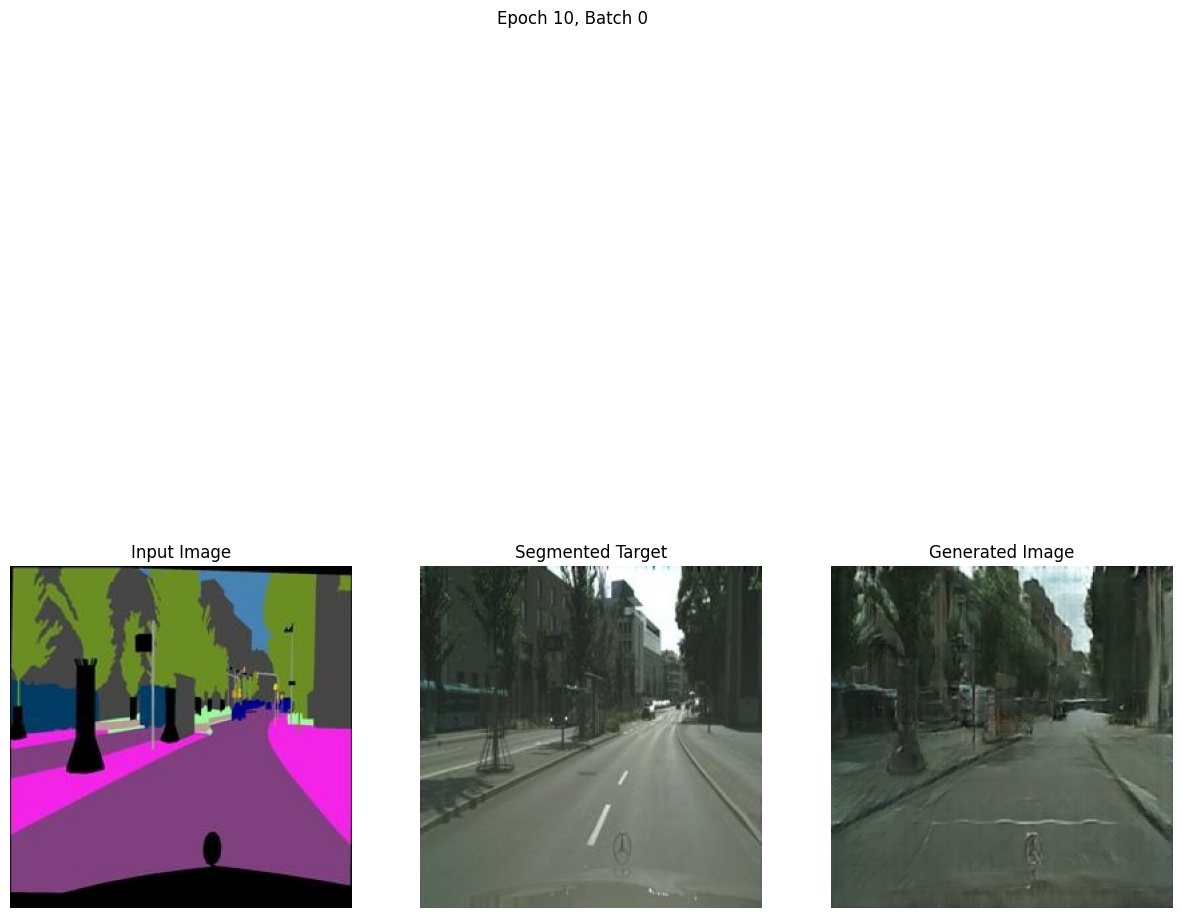

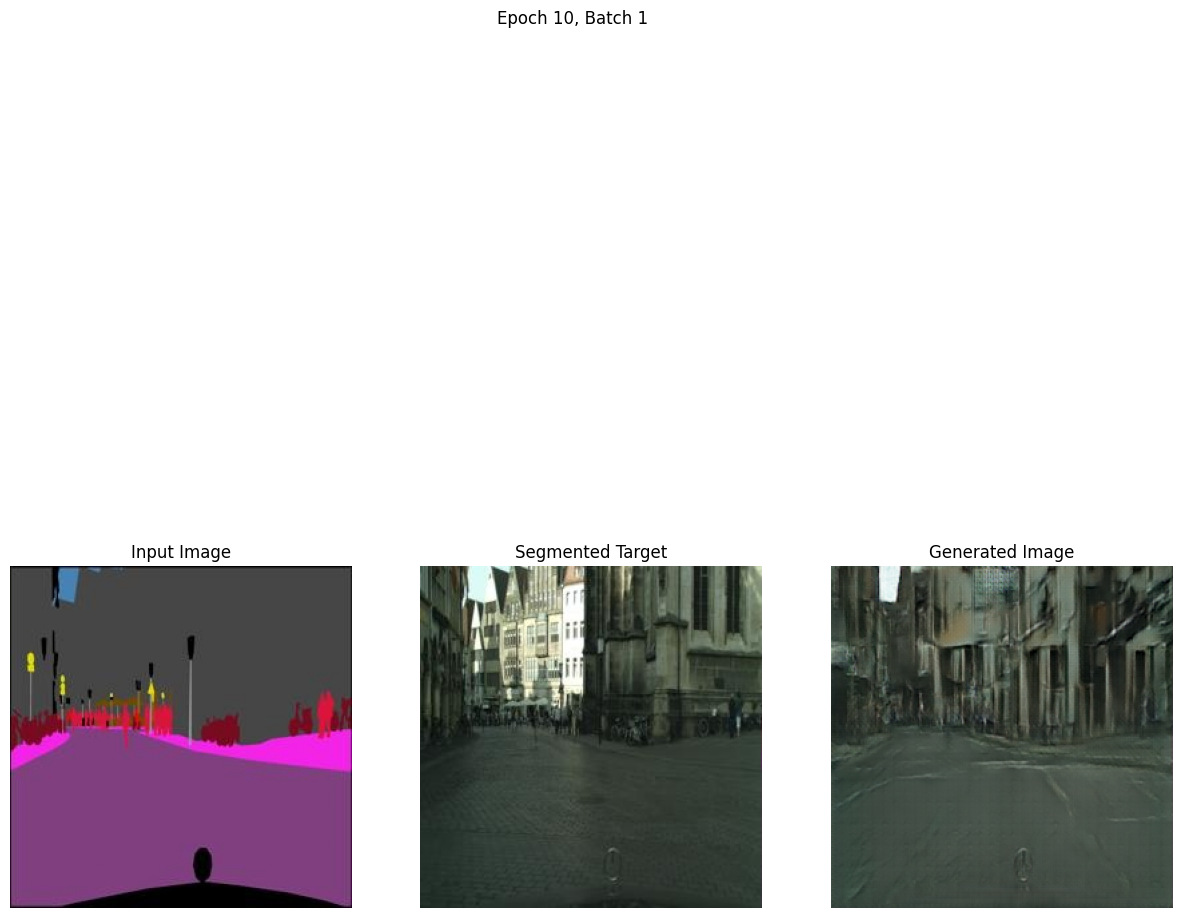

Epoch 11/50
Epoch 11 Training Losses:
  Generator Total Loss: 10.5432
  Generator GAN Loss: 1.5662
  Generator L1 Loss: 0.0898
  Discriminator Loss: 0.9625
Epoch 11 Validation Losses:
  Generator Total Loss: 12.8256
  Generator GAN Loss: 0.9721
  Generator L1 Loss: 0.1185
  Discriminator Loss: 1.2874
Epoch 12/50
Epoch 12 Training Losses:
  Generator Total Loss: 10.3162
  Generator GAN Loss: 1.5848
  Generator L1 Loss: 0.0873
  Discriminator Loss: 0.9548
Epoch 12 Validation Losses:
  Generator Total Loss: 13.4684
  Generator GAN Loss: 1.4972
  Generator L1 Loss: 0.1197
  Discriminator Loss: 1.5478
Epoch 13/50
Epoch 13 Training Losses:
  Generator Total Loss: 10.1249
  Generator GAN Loss: 1.6018
  Generator L1 Loss: 0.0852
  Discriminator Loss: 0.9496
Epoch 13 Validation Losses:
  Generator Total Loss: 12.8352
  Generator GAN Loss: 1.1860
  Generator L1 Loss: 0.1165
  Discriminator Loss: 1.2029
Epoch 14/50
Epoch 14 Training Losses:
  Generator Total Loss: 9.9510
  Generator GAN Loss: 1.6

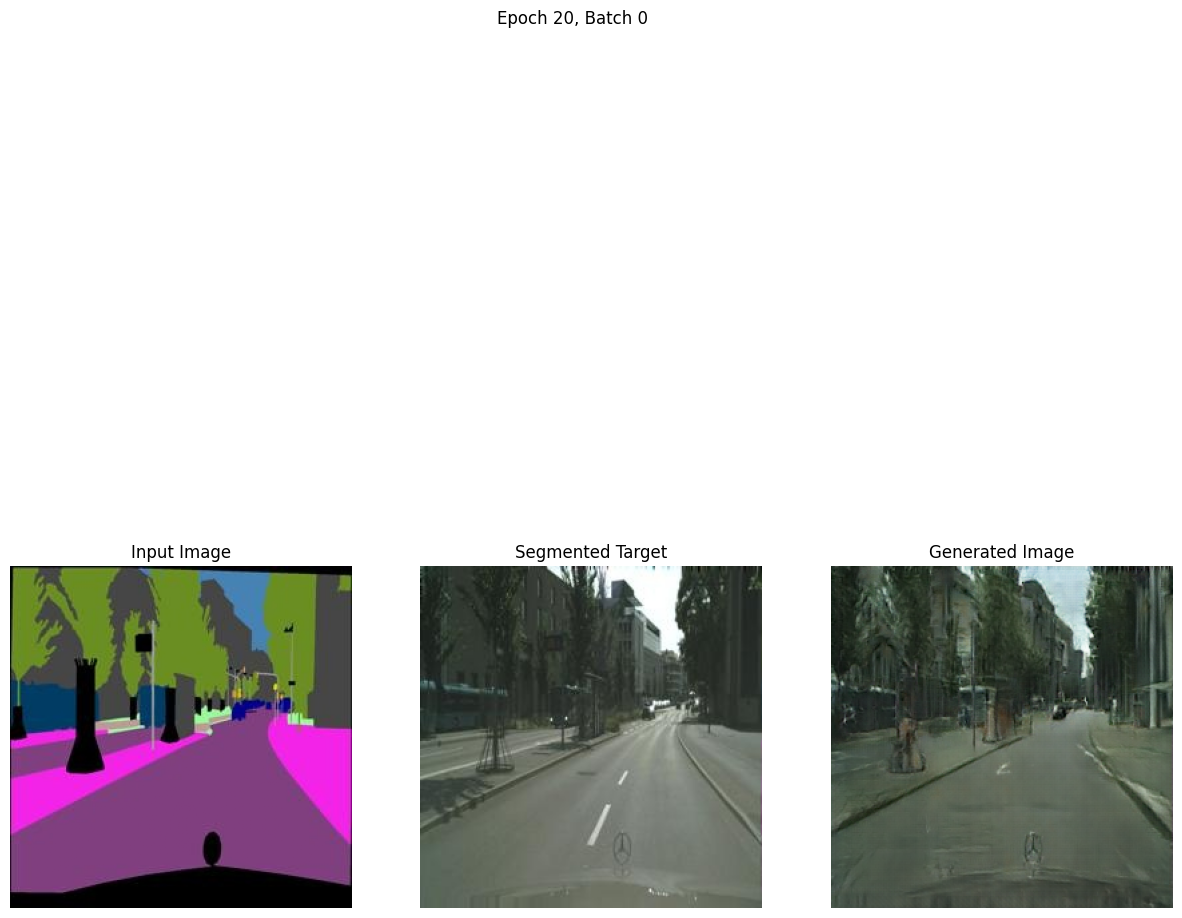

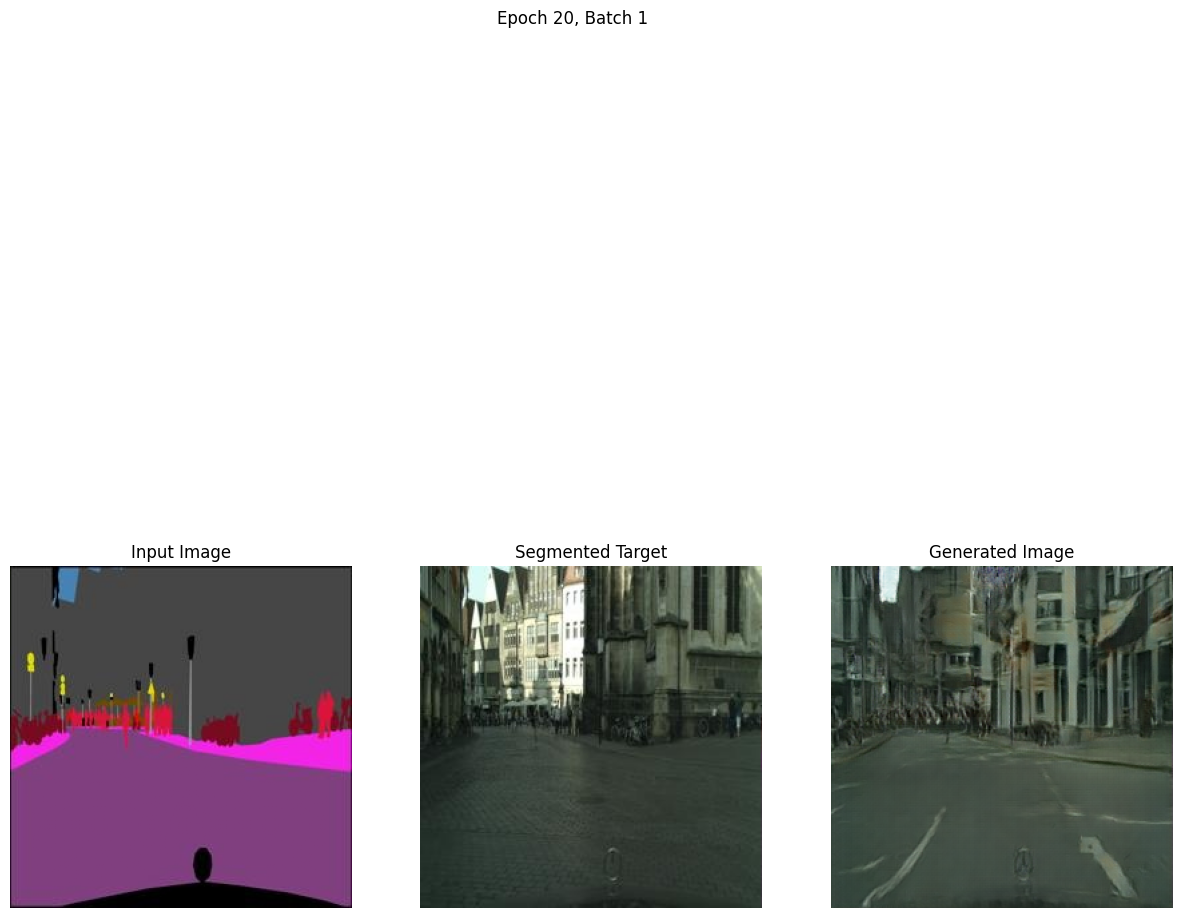

Epoch 21/50
Epoch 21 Training Losses:
  Generator Total Loss: 9.1539
  Generator GAN Loss: 1.8217
  Generator L1 Loss: 0.0733
  Discriminator Loss: 0.8949
Epoch 21 Validation Losses:
  Generator Total Loss: 13.1683
  Generator GAN Loss: 1.2020
  Generator L1 Loss: 0.1197
  Discriminator Loss: 1.3029
Epoch 22/50
Epoch 22 Training Losses:
  Generator Total Loss: 9.0662
  Generator GAN Loss: 1.8314
  Generator L1 Loss: 0.0723
  Discriminator Loss: 0.8931
Epoch 22 Validation Losses:
  Generator Total Loss: 12.6934
  Generator GAN Loss: 1.0376
  Generator L1 Loss: 0.1166
  Discriminator Loss: 1.3392
Epoch 23/50
Epoch 23 Training Losses:
  Generator Total Loss: 9.0169
  Generator GAN Loss: 1.8655
  Generator L1 Loss: 0.0715
  Discriminator Loss: 0.8849
Epoch 23 Validation Losses:
  Generator Total Loss: 12.3109
  Generator GAN Loss: 1.1207
  Generator L1 Loss: 0.1119
  Discriminator Loss: 1.2859
Epoch 24/50
Epoch 24 Training Losses:
  Generator Total Loss: 9.0125
  Generator GAN Loss: 1.9312

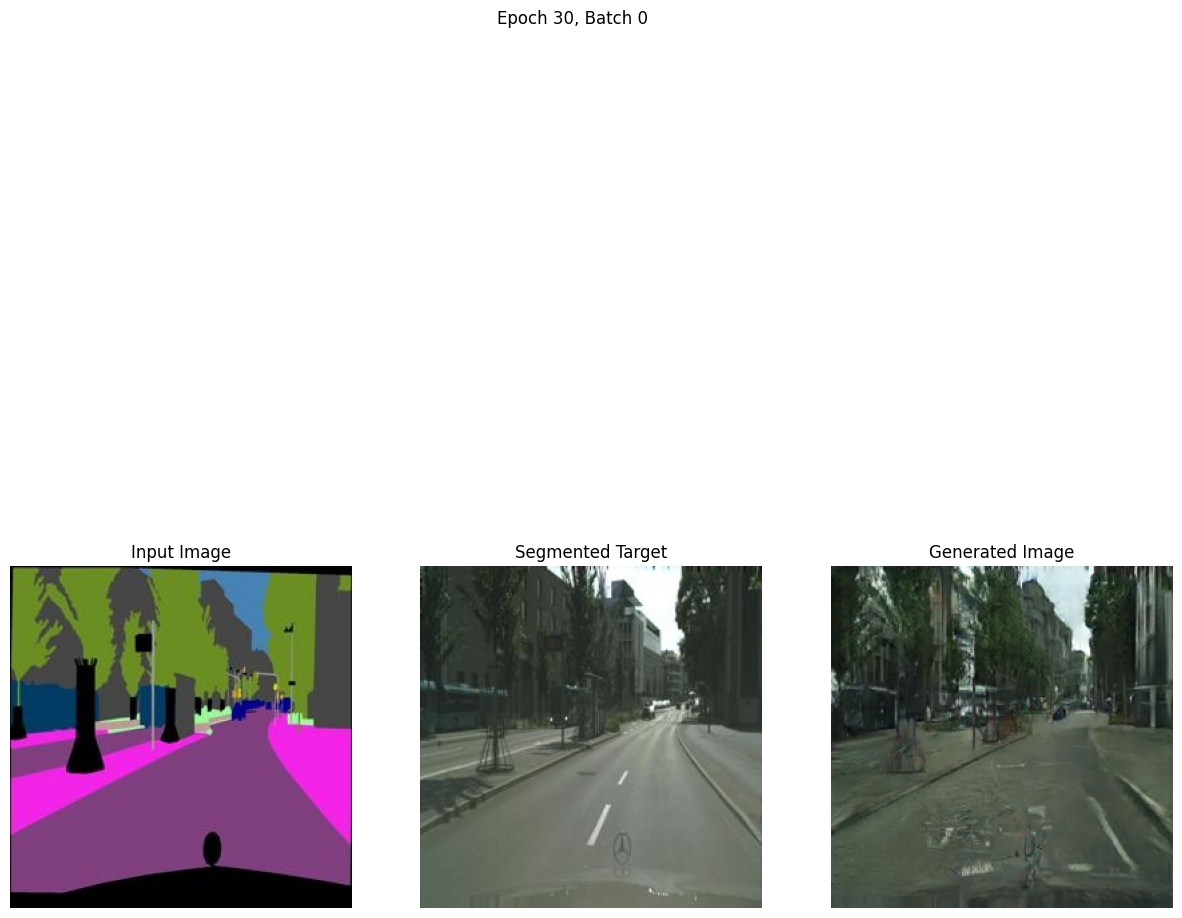

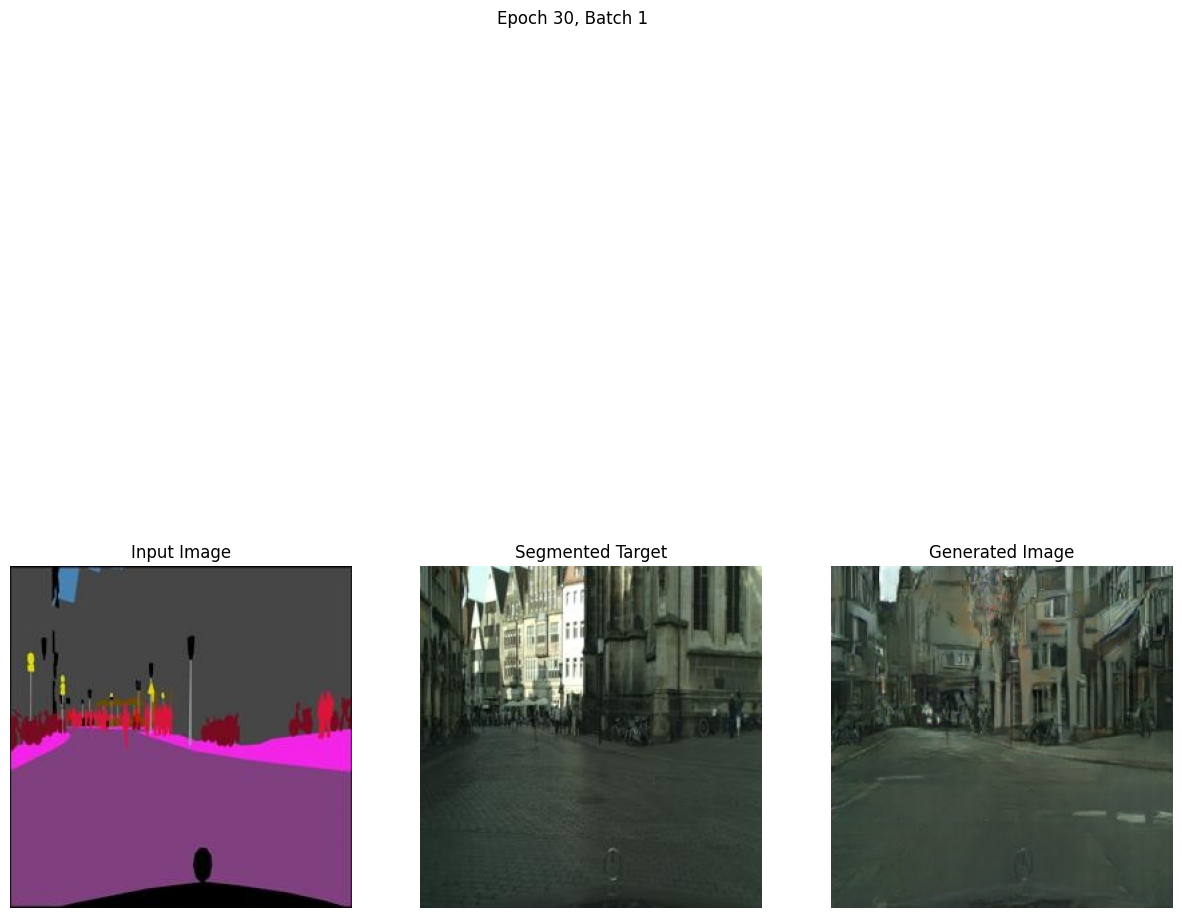

Epoch 31/50
Epoch 31 Training Losses:
  Generator Total Loss: 9.3699
  Generator GAN Loss: 2.5443
  Generator L1 Loss: 0.0683
  Discriminator Loss: 0.7021
Epoch 31 Validation Losses:
  Generator Total Loss: 13.3747
  Generator GAN Loss: 1.7897
  Generator L1 Loss: 0.1159
  Discriminator Loss: 1.1085
Epoch 32/50
Epoch 32 Training Losses:
  Generator Total Loss: 9.4197
  Generator GAN Loss: 2.6203
  Generator L1 Loss: 0.0680
  Discriminator Loss: 0.6781
Epoch 32 Validation Losses:
  Generator Total Loss: 13.8497
  Generator GAN Loss: 2.1388
  Generator L1 Loss: 0.1171
  Discriminator Loss: 1.7556
Epoch 33/50
Epoch 33 Training Losses:
  Generator Total Loss: 9.5455
  Generator GAN Loss: 2.7457
  Generator L1 Loss: 0.0680
  Discriminator Loss: 0.6379
Epoch 33 Validation Losses:
  Generator Total Loss: 13.2233
  Generator GAN Loss: 1.8644
  Generator L1 Loss: 0.1136
  Discriminator Loss: 0.9889
Epoch 34/50
Epoch 34 Training Losses:
  Generator Total Loss: 9.6495
  Generator GAN Loss: 2.8585

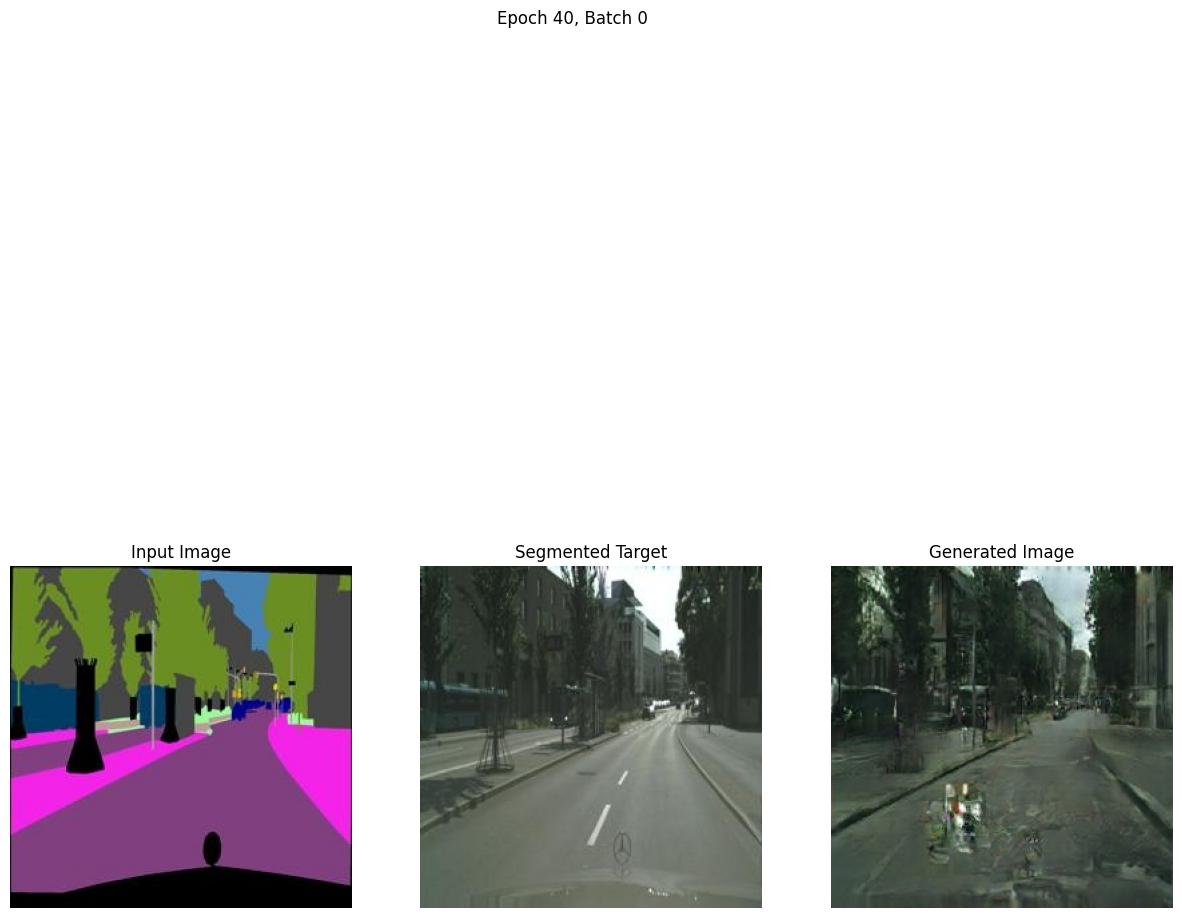

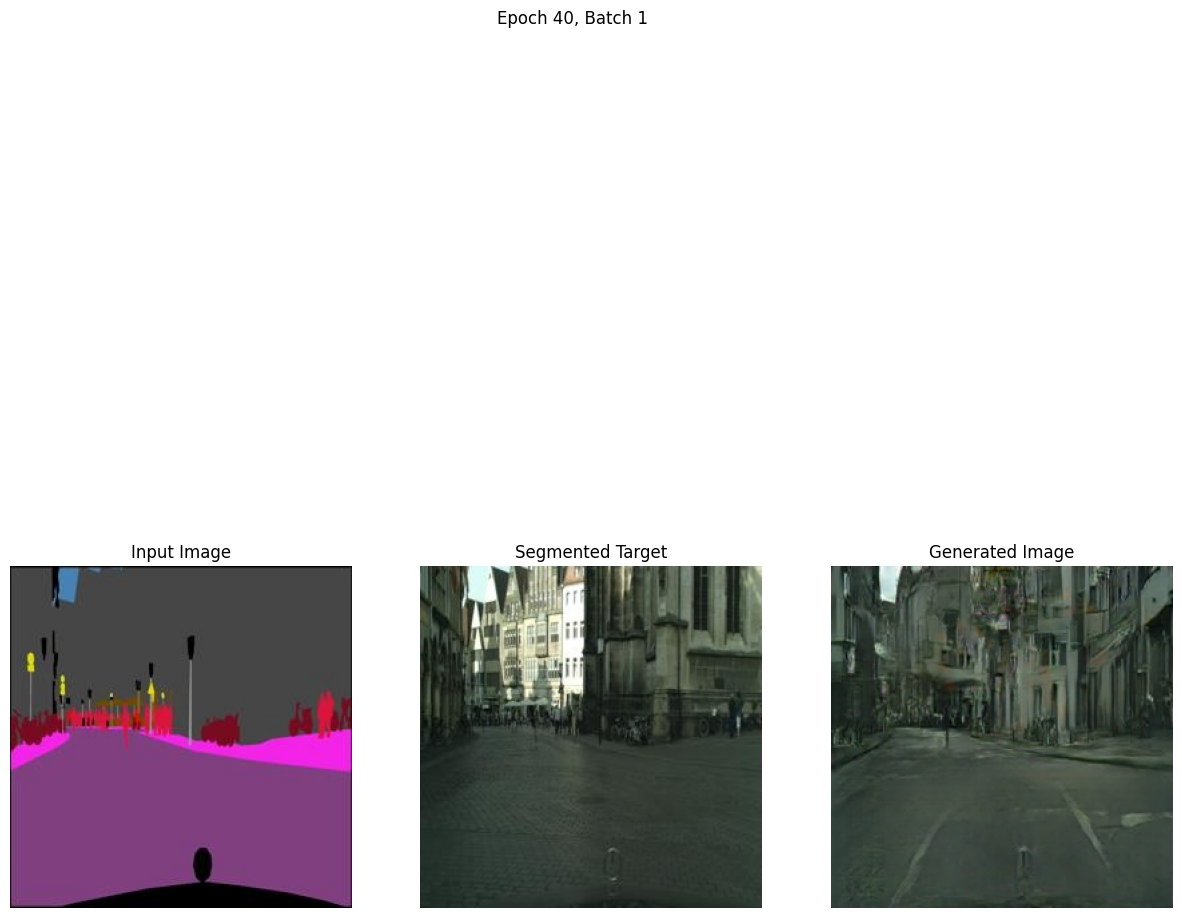

Epoch 41/50
Epoch 41 Training Losses:
  Generator Total Loss: 10.3589
  Generator GAN Loss: 3.4807
  Generator L1 Loss: 0.0688
  Discriminator Loss: 0.4924
Epoch 41 Validation Losses:
  Generator Total Loss: 13.3332
  Generator GAN Loss: 1.8498
  Generator L1 Loss: 0.1148
  Discriminator Loss: 1.2102
Epoch 42/50
Epoch 42 Training Losses:
  Generator Total Loss: 10.5452
  Generator GAN Loss: 3.6325
  Generator L1 Loss: 0.0691
  Discriminator Loss: 0.4657
Epoch 42 Validation Losses:
  Generator Total Loss: 24.0758
  Generator GAN Loss: 11.9722
  Generator L1 Loss: 0.1210
  Discriminator Loss: 0.8289
Epoch 43/50
Epoch 43 Training Losses:
  Generator Total Loss: 10.6078
  Generator GAN Loss: 3.6778
  Generator L1 Loss: 0.0693
  Discriminator Loss: 0.4610
Epoch 43 Validation Losses:
  Generator Total Loss: 13.8412
  Generator GAN Loss: 2.0800
  Generator L1 Loss: 0.1176
  Discriminator Loss: 1.0015
Epoch 44/50
Epoch 44 Training Losses:
  Generator Total Loss: 10.7256
  Generator GAN Loss: 3

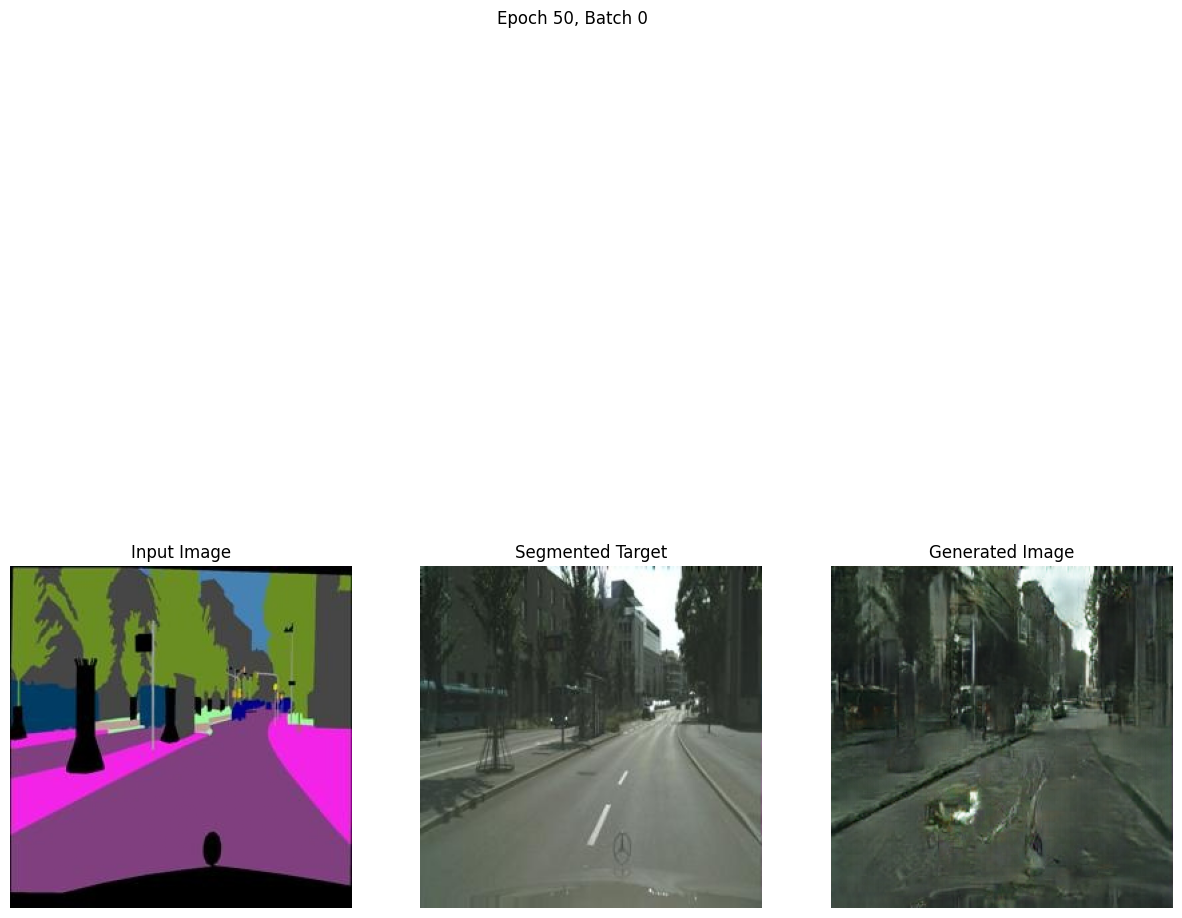

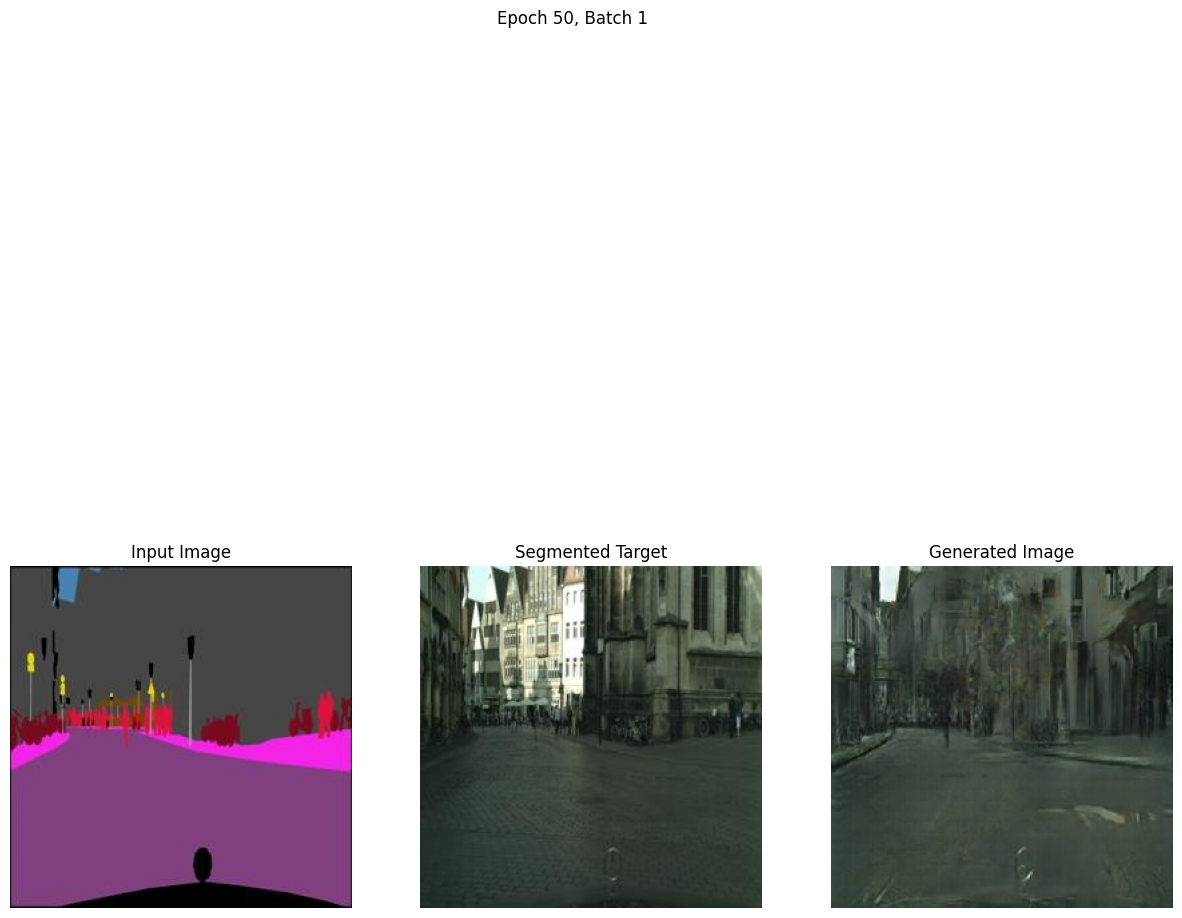

Final Results:


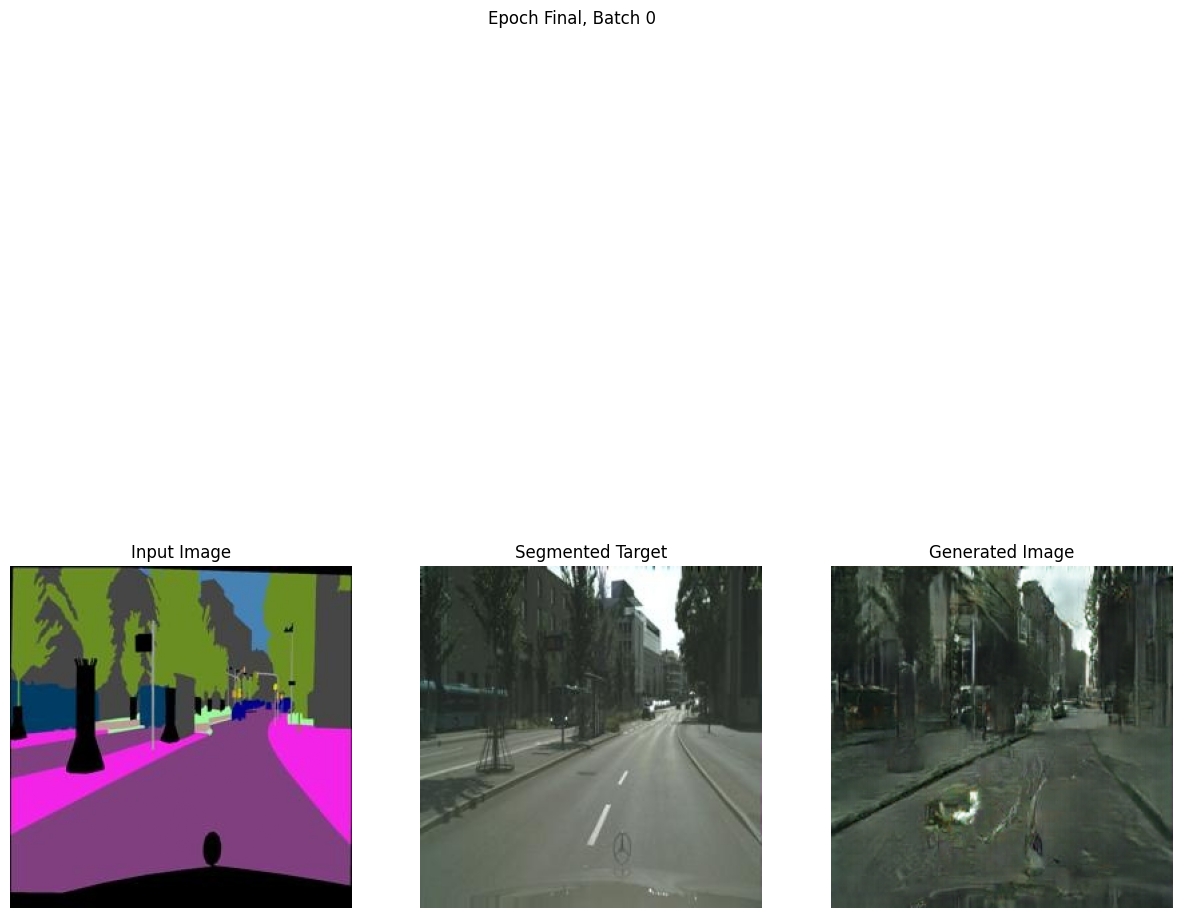

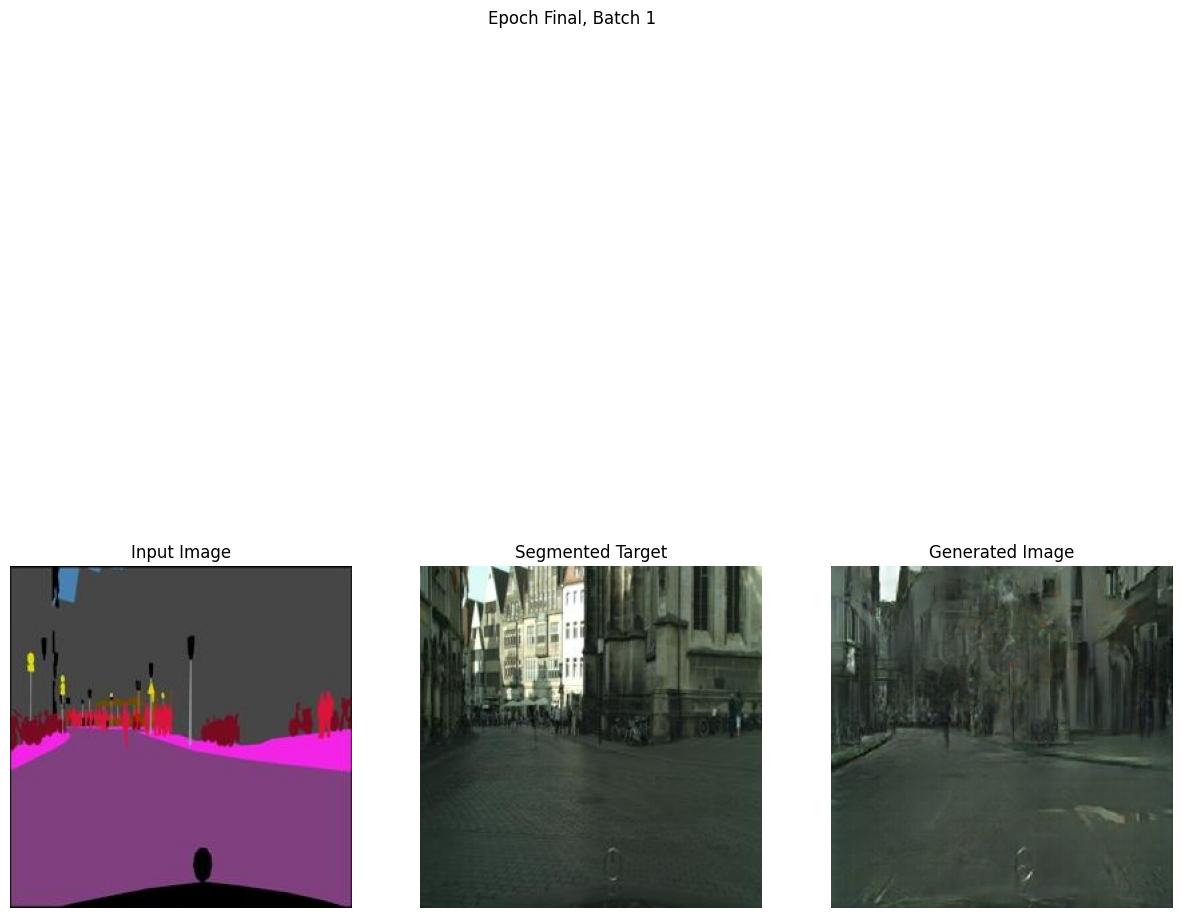

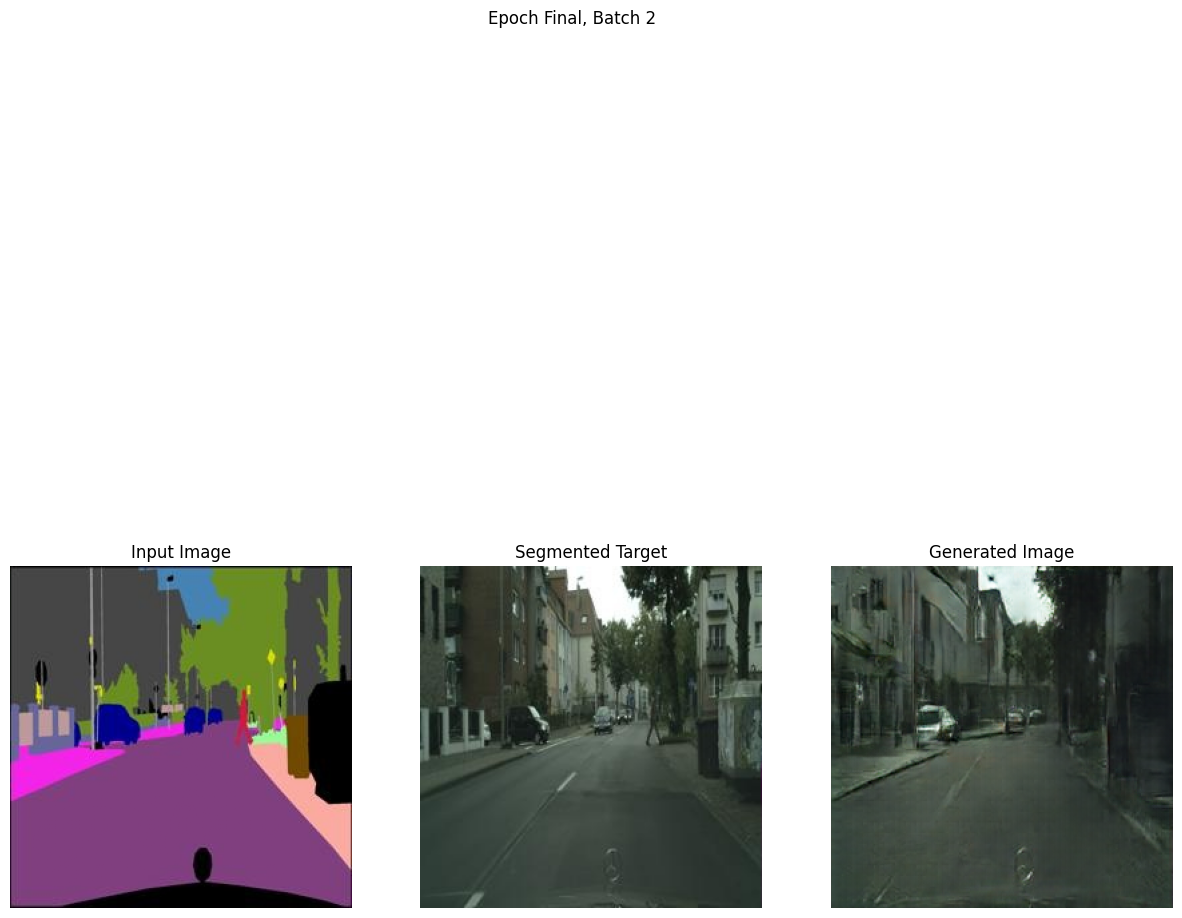

In [26]:
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")
    
    # Initialize loss accumulators for training and validation
    train_loss_accumulator = {
        "gen_total_loss": [],
        "gen_gan_loss": [],
        "gen_l1_loss": [],
        "disc_loss": []
    }
    val_loss_accumulator = {
        "gen_total_loss": [],
        "gen_gan_loss": [],
        "gen_l1_loss": [],
        "disc_loss": []
    }

    # Training phase
    for step, (input_image, target_image) in enumerate(train_loader):
        input_image = input_image.to(device)
        target_image = target_image.to(device)

        train_step(generator, discriminator, generator_optimizer, discriminator_optimizer,
                   input_image, target_image, train_loss_accumulator)

    # Validation phase
    for step, (val_input_image, val_target_image) in enumerate(test_loader):
        val_input_image = val_input_image.to(device)
        val_target_image = val_target_image.to(device)

        validation_step(generator, discriminator, val_input_image, val_target_image, val_loss_accumulator)

    # Compute average training losses for the epoch
    avg_train_gen_total_loss = sum(train_loss_accumulator["gen_total_loss"]) / len(train_loss_accumulator["gen_total_loss"])
    avg_train_gen_gan_loss = sum(train_loss_accumulator["gen_gan_loss"]) / len(train_loss_accumulator["gen_gan_loss"])
    avg_train_gen_l1_loss = sum(train_loss_accumulator["gen_l1_loss"]) / len(train_loss_accumulator["gen_l1_loss"])
    avg_train_disc_loss = sum(train_loss_accumulator["disc_loss"]) / len(train_loss_accumulator["disc_loss"])

    # Compute average validation losses for the epoch
    avg_val_gen_total_loss = sum(val_loss_accumulator["gen_total_loss"]) / len(val_loss_accumulator["gen_total_loss"])
    avg_val_gen_gan_loss = sum(val_loss_accumulator["gen_gan_loss"]) / len(val_loss_accumulator["gen_gan_loss"])
    avg_val_gen_l1_loss = sum(val_loss_accumulator["gen_l1_loss"]) / len(val_loss_accumulator["gen_l1_loss"])
    avg_val_disc_loss = sum(val_loss_accumulator["disc_loss"]) / len(val_loss_accumulator["disc_loss"])

    # Append to global loss history
    train_loss_history["gen_total_loss"].append(avg_train_gen_total_loss)
    train_loss_history["gen_gan_loss"].append(avg_train_gen_gan_loss)
    train_loss_history["gen_l1_loss"].append(avg_train_gen_l1_loss)
    train_loss_history["disc_loss"].append(avg_train_disc_loss)

    val_loss_history["gen_total_loss"].append(avg_val_gen_total_loss)
    val_loss_history["gen_gan_loss"].append(avg_val_gen_gan_loss)
    val_loss_history["gen_l1_loss"].append(avg_val_gen_l1_loss)
    val_loss_history["disc_loss"].append(avg_val_disc_loss)

    # Print losses for the epoch
    print(f"Epoch {epoch} Training Losses:")
    print(f"  Generator Total Loss: {avg_train_gen_total_loss:.4f}")
    print(f"  Generator GAN Loss: {avg_train_gen_gan_loss:.4f}")
    print(f"  Generator L1 Loss: {avg_train_gen_l1_loss:.4f}")
    print(f"  Discriminator Loss: {avg_train_disc_loss:.4f}")

    print(f"Epoch {epoch} Validation Losses:")
    print(f"  Generator Total Loss: {avg_val_gen_total_loss:.4f}")
    print(f"  Generator GAN Loss: {avg_val_gen_gan_loss:.4f}")
    print(f"  Generator L1 Loss: {avg_val_gen_l1_loss:.4f}")
    print(f"  Discriminator Loss: {avg_val_disc_loss:.4f}")

    if epoch % 10 == 0:
        generator.eval()
        with torch.no_grad():
            for batch_idx, (test_input, test_target) in enumerate(test_loader):
                test_input = test_input.to(device)
                test_target = test_target.to(device)

                generated_image = generator(test_input)
                
                display_images(test_input, test_target, generated_image, epoch, batch_idx)
                
                if batch_idx >= 1:
                    break
print("Final Results:")
generator.eval()
with torch.no_grad():
    for batch_idx, (test_input, test_target) in enumerate(test_loader):
        test_input = test_input.to(device)
        test_target = test_target.to(device)

        final_generated_image = generator(test_input)

        display_images(test_input, test_target, final_generated_image, "Final", batch_idx)

        if batch_idx >= 2:
            break

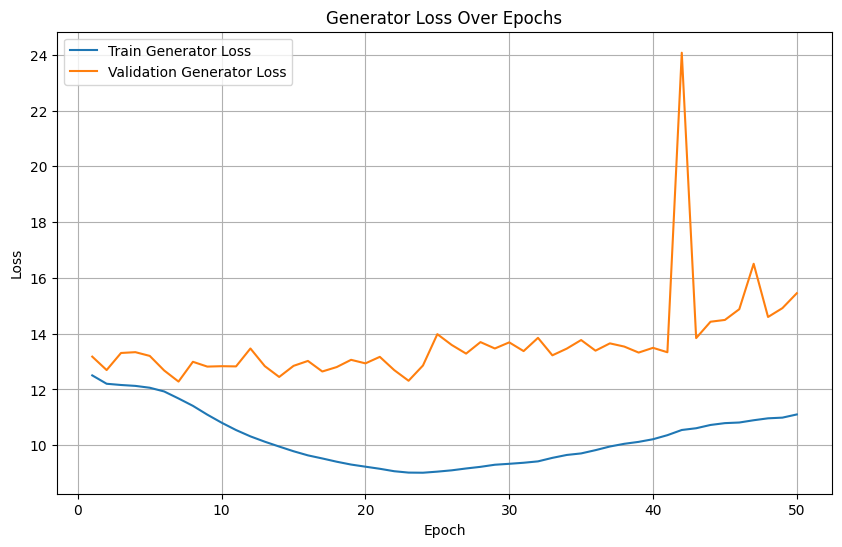

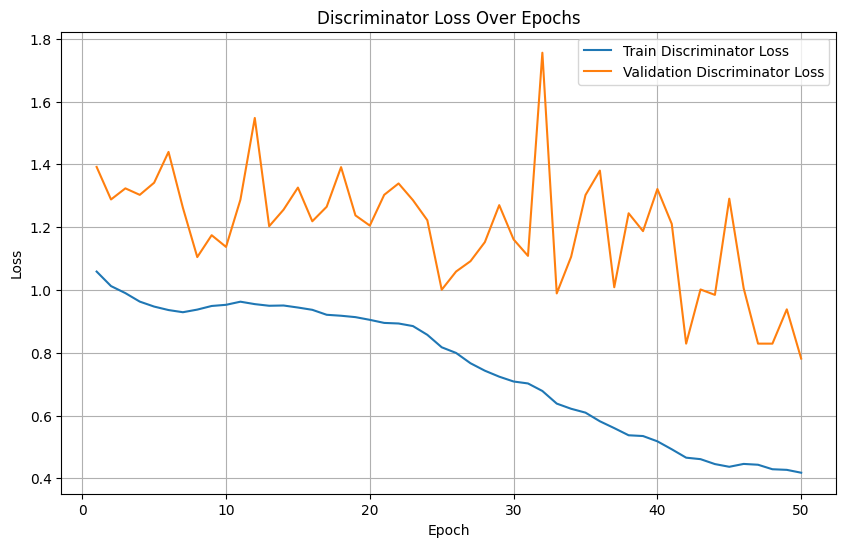

In [27]:
import matplotlib.pyplot as plt

# Function to plot the loss of Generator and Discriminator over epochs
def plot_loss(train_loss_history, val_loss_history):
    # Extract the number of epochs based on the training history
    epochs = range(1, len(train_loss_history["gen_total_loss"]) + 1)
    
    # Plot Generator Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss_history["gen_total_loss"], label="Train Generator Loss")  # Training loss for Generator
    plt.plot(epochs, val_loss_history["gen_total_loss"], label="Validation Generator Loss")  # Validation loss for Generator
    plt.xlabel("Epoch")  # X-axis label
    plt.ylabel("Loss")  # Y-axis label
    plt.title("Generator Loss Over Epochs")  # Title of the chart
    plt.legend()  # Add legend to distinguish between train and validation losses
    plt.grid()  # Add gridlines for better readability
    plt.show()  # Display the plot

    # Plot Discriminator Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss_history["disc_loss"], label="Train Discriminator Loss")  # Training loss for Discriminator
    plt.plot(epochs, val_loss_history["disc_loss"], label="Validation Discriminator Loss")  # Validation loss for Discriminator
    plt.xlabel("Epoch")  # X-axis label
    plt.ylabel("Loss")  # Y-axis label
    plt.title("Discriminator Loss Over Epochs")  # Title of the chart
    plt.legend()  # Add legend to distinguish between train and validation losses
    plt.grid()  # Add gridlines for better readability
    plt.show()  # Display the plot

# Call the function with training and validation loss histories
# Make sure these dictionaries are populated during the training process
plot_loss(train_loss_history, val_loss_history)
